<a href="https://colab.research.google.com/github/mfilipak/AFRAC_IA/blob/main/006B_Experimentos%20aleat%C3%B3rios%20com%20CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import requests
import os
import pandas as pd

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from mpl_toolkits import mplot3d
import plotly.express as px

In [10]:
model = tf.keras.models.load_model("CNN1D_DESC_NCMt.H5", compile=False)

In [5]:
#Copia os dados das NFEs do portal da cidadância pro drive virtual.
import requests  

DATA_FILE = "AFRAC-20220506.zip"
df = pd.read_csv(DATA_FILE, encoding='utf-8-sig',sep=";", decimal=',')
#(csv_file_name,encoding='utf-8-sig', sep =';', decimal=',', index=False)
print("O dataframe completo contém:",len(df),"linhas")

df3 = df[['Data de Emissão - Documento Fiscal','Descrição do Item', 'NCM', 'GTIN/EAN Comercial']]
df3.columns = ["DATA", "DESCR", "NCM", "GTIN"]
#df3 = df3[df3["NCM"]!=-1] #Filtrando NCMs = -1

text_lengths = np.array([len(_) for _ in df3['DESCR']])
df3 = df3[text_lengths>=3]

#Caso queira eliminar as repetições rodar a linha abaixo
df3 = df3.drop_duplicates(subset=["DESCR", "NCM", "GTIN"])
print("O dataframe sem repetiçoes contém:",len(df3),"linhas")
df3[:1]

O dataframe completo contém: 1363510 linhas
O dataframe sem repetiçoes contém: 1105737 linhas


,DATA,DESCR,NCM,GTIN
0,2022-03-05,!!!!! AGUA COM GAS 500ML,22021000,-1


In [6]:
descs = [_.lower() for _ in df3["DESCR"]]
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(descs)
print(tk.word_index)
print(f"{len(tk.word_index)} caracteres.")
print("".join(sorted([_ for _ in tk.word_index])))
descs = [_+(120-len(_))*" " for _ in descs]
df3["DESCR_NORM"] = descs
df3[-5:]

{'UNK': 1, ' ': 2, 'a': 3, 'o': 4, 'e': 5, 'r': 6, 'i': 7, 'c': 8, 'l': 9, 's': 10, 't': 11, 'n': 12, 'm': 13, '0': 14, 'p': 15, 'g': 16, 'd': 17, 'u': 18, 'b': 19, '1': 20, 'f': 21, 'h': 22, '2': 23, '5': 24, 'v': 25, '3': 26, 'k': 27, '4': 28, '.': 29, 'x': 30, '6': 31, '8': 32, '-': 33, '7': 34, '9': 35, 'j': 36, 'z': 37, '/': 38, 'y': 39, 'q': 40, 'w': 41, ',': 42, ':': 43, '(': 44, ')': 45, '_': 46, '#': 47, '+': 48, '*': 49, '%': 50, '"': 51, "'": 52, 'ç': 53, '&': 54, 'ã': 55, ';': 56, ']': 57, '[': 58, '$': 59, 'á': 60, '\\': 61, '|': 62, 'é': 63, 'º': 64, 'ó': 65, '!': 66, '=': 67, 'í': 68, 'ê': 69, '?': 70, '>': 71, '@': 72, '¿': 73, '°': 74, 'ú': 75, '\xa0': 76, 'ô': 77, 'â': 78, '`': 79, 'à': 80, 'õ': 81, 'ï': 82, 'ª': 83, '²': 84, '{': 85, '<': 86, '~': 87, 'è': 88, '§': 89, 'ø': 90, 'ñ': 91, '³': 92, 'û': 93, 'ù': 94, '\xad': 95, '}': 96, '\x81': 97, 'ä': 98, 'ü': 99, '¶': 100, '^': 101, '€': 102, '¹': 103, 'µ': 104, '®': 105, '¡': 106}
106 caracteres.
 !"#$%&'()*+,-./012

,DATA,DESCR,NCM,GTIN,DESCR_NORM
1363505,2022-03-05,ÓLEO DE SEMENTE DE ABÓBORA CAP. 80/1000mg - GL...,21069030,7898568353873,óleo de semente de abóbora cap. 80/1000mg - gl...
1363506,2022-03-05,Óleo de Soja Liza 900Ml,15079011,7896036090244,óleo de soja liza 900ml ...
1363507,2022-03-05,Óleo Essencial Hortelã BioEssência - 10ml,33012990,7898937573192,óleo essencial hortelã bioessência - 10ml ...
1363508,2022-03-05,Óleo Essencial Lavanda Francesa BioEssência - ...,33012990,7898937573246,óleo essencial lavanda francesa bioessência - ...
1363509,2022-03-05,Óleo Motor 20w50 Havoline,27101932,-1,óleo motor 20w50 havoline ...


In [7]:
samples = list(df3["DESCR_NORM"]) #.sample(1000))

In [8]:
# Convert string to index
X_sequences = tk.texts_to_sequences(samples)
X = np.array(X_sequences, dtype='float32')
X.shape

(1105737, 120)

In [9]:
layer = model.layers[-3]
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=layer.output)
embeds = intermediate_layer_model.predict(X)
embeds.shape

NameError: ignored

In [63]:
query = "cenoura"
q_embed = intermediate_layer_model.predict(np.array(tk.texts_to_sequences([query+(120-len(query))*" "]), dtype='float32'))
dists = ((q_embed-embeds)**2).sum(axis=-1)
qsort = np.argsort(dists)
[ [dists[_], df3["DESCR"].iloc[_]] for _ in qsort[:50]]

[[3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'Cenoura'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'Cenoura'],
 [3.0538683e-10, 'cenoura'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'cenoura'],
 [3.0538683e-10, 'Cenoura'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'Cenoura'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [3.0538683e-10, 'CENOURA'],
 [1.3385769, 'Rhino'],
 [1.3745574, 'ADAMS HORTELA'],
 [1.4359617, 'ADD MILHO VERDE'],
 [1.6670454, 'A ALHO INDUSTRIA'],
 [1.8174691, 'ALECRIN MC'],
 [2.1193197, 'OLHO GREGO'],
 [2.1193197, 'OLHO GREGO'],
 [2.2213378, 'AGRIAO UNI'],
 [2.2213378, 'AGRIAO UNI'],
 [2.4281263, 'HORTELA FRESCO'],
 [2.7195597, 'TOMATE A'],
 [2.7720504, 'CEBOLA PEQUENA'],
 [2.8500552, 'PURE PQ'],
 [3.0971432, 'A

In [66]:
query = "sapato masculino"
q_embed = intermediate_layer_model.predict(np.array(tk.texts_to_sequences([query+(120-len(query))*" "]), dtype='float32'))
query = "sapato feminino"
q_embed -= intermediate_layer_model.predict(np.array(tk.texts_to_sequences([query+(120-len(query))*" "]), dtype='float32'))
query = "calça feminina"
q_embed += intermediate_layer_model.predict(np.array(tk.texts_to_sequences([query+(120-len(query))*" "]), dtype='float32'))

dists = ((q_embed-embeds)**2).sum(axis=-1)
qsort = np.argsort(dists)
[ [dists[_], df3["DESCR"].iloc[_]] for _ in qsort[:50]]

[[36.121235, 'CAMISA VOLTA AO MUND'],
 [36.974014, 'VESTIDO FESTA MINI MISS'],
 [37.440567, 'BLAZER DONGIL SMOK'],
 [37.493103, 'CALCA GESSNER'],
 [37.511192, 'CROPPED CHOKER SILK BANDA'],
 [37.74518, 'CALCA FILA FEM FLAT SUMMER'],
 [37.753395, 'MACACAO SOFT 4-8'],
 [37.831665, 'CAVIAR STICK EYE COLOUR  SIENNA'],
 [38.194057, 'VESTIDO PROGRAMA'],
 [38.194057, 'VESTIDO PROGRAMA'],
 [38.44769, 'CALCA PANTALONA CAMADAS'],
 [38.512283, 'PIJAMA LONGO MDL Tam: M'],
 [38.607216, 'VESTIDO BRILHOSO'],
 [38.868057, 'SHORT 21539 FULL FLORES F.13'],
 [38.898872, 'VESTIDO PP CAT ROSA'],
 [39.04793, 'Macaquinho P Pet Games'],
 [39.06722, 'MACACAO/VESTIDO DIVERSOS'],
 [39.072113, 'CALCA Tam.:G'],
 [39.341644, 'CALCA BIVIK O'],
 [39.348263, 'Jaqueta   Pequena Mania 6 ANOS'],
 [39.369747, 'CROPPED TOP CANELADO MODAL'],
 [39.4853, 'CUECA BOX ADT COTTON REF 09'],
 [39.49508, 'TOP RENDA COMPRIDO'],
 [39.53953, 'CALCA 3650 ALFA'],
 [39.53953, 'CALCA 3650 ALFA'],
 [39.544983, 'SHORTS M 3S BLACKGRESIX L'],
 

In [11]:
capitulos = [ int(f"{_:08}"[:2]) for _ in df3["NCM"] ]
df3["CAPITULO"] = capitulos
print(f"Capítulos encontrados no NCM: {len(df3['CAPITULO'].unique())}")

Capítulos encontrados no NCM: 97


In [12]:
pred = model.predict(X)
df3["CAP_PRED"] = [ np.argmax(_) for _ in pred[:]]
df3

,DATA,DESCR,NCM,GTIN,DESCR_NORM,CAPITULO,CAP_PRED
0,2022-03-05,!!!!! AGUA COM GAS 500ML,22021000,-1,!!!!! agua com gas 500ml ...,22,22
2,2022-03-05,!!!!! AGUA SEM GAS 500ML,22021000,-1,!!!!! agua sem gas 500ml ...,22,22
4,2022-03-05,!AGUA SANITARIA,28289019,-1,!agua sanitaria ...,28,28
5,2022-03-05,!ALCOOL 70%,38089429,-1,!alcool 70% ...,38,38
6,2022-03-05,!ALFACE AMERICANA FATIADA PCT,7051100,-1,!alface americana fatiada pct ...,7,7
...,...,...,...,...,...,...,...
1363505,2022-03-05,ÓLEO DE SEMENTE DE ABÓBORA CAP. 80/1000mg - GL...,21069030,7898568353873,óleo de semente de abóbora cap. 80/1000mg - gl...,21,21
1363506,2022-03-05,Óleo de Soja Liza 900Ml,15079011,7896036090244,óleo de soja liza 900ml ...,15,15
1363507,2022-03-05,Óleo Essencial Hortelã BioEssência - 10ml,33012990,7898937573192,óleo essencial hortelã bioessência - 10ml ...,33,33
1363508,2022-03-05,Óleo Essencial Lavanda Francesa BioEssência - ...,33012990,7898937573246,óleo essencial lavanda francesa bioessência - ...,33,33


In [77]:
reps = df3["DESCR"].value_counts()[df3["DESCR"].value_counts()>1].index

In [138]:

acc=0
for i in reps[:]:
  cap_pred = df3[df3["DESCR"]==i]["CAP_PRED"].iloc[0]
  caps = df3[df3["DESCR"]==i]["CAPITULO"]
  if (  caps.value_counts().index[0] ==  cap_pred):
    acc+=(caps != cap_pred).sum()
    print(acc)


Streaming output truncated to the last 5000 lines.
13581
13581
13581
13581
13581
13581
13581
13581
13582
13582
13583
13583
13583
13584
13584
13584
13584
13584
13585
13585
13585
13585
13586
13586
13586
13586
13586
13587
13587
13588
13588
13588
13589
13589
13589
13589
13589
13589
13589
13589
13590
13590
13590
13590
13591
13591
13591
13591
13591
13591
13591
13591
13592
13592
13592
13592
13593
13593
13593
13593
13593
13593
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13594
13595
13595
13595
13595
13596
13597
13597
13597
13597
13597
13597
13598
13598
13598
13598
13598
13598
13598
13599
13599
13599
13599
13599
13599
13599
13599
13599
13600
13600
13600
13600
13600
13600
13600
1

KeyboardInterrupt: ignored

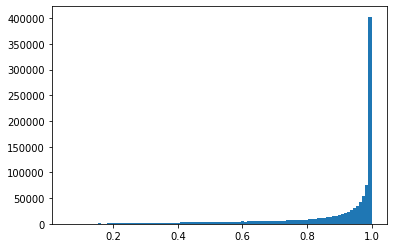

In [13]:
plt.hist(pred.max(axis=-1), bins=100)
plt.show()

In [ ]:
#df3[pred<0.5]

In [96]:
df3.loc[df3[df3["DESCR"]==reps[2]]["CAPITULO"].index]

,DATA,DESCR,NCM,GTIN,DESCR_NORM,CAPITULO,CAP_PRED
947189,2022-03-05,PAO FRANCES,19059090,-1,pao frances ...,19,19
947190,2022-03-05,PAO FRANCES,22030000,-1,pao frances ...,22,19
947193,2022-03-05,PAO FRANCES,19052090,-1,pao frances ...,19,19
947195,2022-03-05,PAO FRANCES,19059010,-1,pao frances ...,19,19
947197,2022-03-05,PAO FRANCES,-1,-1,pao frances ...,0,19
947198,2022-03-05,PAO FRANCES,21069090,-1,pao frances ...,21,19
947207,2022-03-05,PAO FRANCES,19059090,7890000006088,pao frances ...,19,19
947208,2022-03-05,PAO FRANCES,19012000,-1,pao frances ...,19,19
947214,2022-03-05,PAO FRANCES,19053100,-1,pao frances ...,19,19
947225,2022-03-05,PAO FRANCES,19059090,7890000000017,pao frances ...,19,19


In [91]:
pred[df3["DESCR"]==reps[2]]["CAPITULO"].index]

SyntaxError: ignored

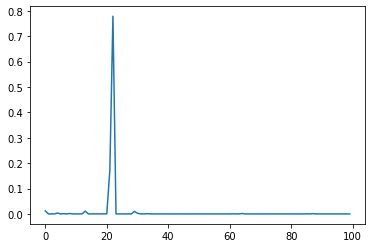

In [95]:
plt.plot(pred[947490])